## About exp
- March Mania 2021

## Library

In [1]:
# library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import lightgbm as lgb

from tqdm import tqdm_notebook as tqdm

from gensim.models import word2vec, KeyedVectors
import pycld2 as cld2

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

/Users/kazuki/.pyenv/versions/anaconda3-2020.02/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


## Config

In [2]:
# Config
SEED = 1010
SHUFFLE = True
N_SPLITS = 5
TRAIN = True

EXP = '001'

LGBM_PARAMS = {
    'num_leaves': 200,
    'max_bin':350,
    'objective': 'rmse',
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'random_state': SEED,
    'metric':'rmse',
}

LGBM_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 50,
    'verbose_eval': 100,
}

## Function

In [3]:
def train_lgbm(X_train, y_train, X_valid, y_valid, X_test, categorical_features, fold_id, lgb_params, fit_params, loss_func, calc_importances=True):

    train = lgb.Dataset(X_train, y_train,
                        categorical_feature=categorical_features,
                        #feature_name=feature_name
                        )

    if X_valid is not None:
        valid = lgb.Dataset(X_valid, y_valid,
                            categorical_feature=categorical_features,
                            #feature_name=feature_name
                            )

    if X_valid is not None:
        model = lgb.train(
            lgb_params,
            train,
            valid_sets=[train,valid],
            **fit_params
        )
    else:
        model = lgb.train(
            lgb_params,
            train,
            **fit_params
        )

    # train score
    if X_valid is not None:
        y_pred_valid = model.predict(X_valid)
        valid_loss = loss_func(y_valid, y_pred_valid)
    else:
        y_pred_valid = None
        valid_loss = None

    #test
    if X_test is not None:
        y_pred_test = model.predict(X_test)
    else:
        y_pred_test = None

    #importance
    if calc_importances:
        importances = pd.DataFrame()
        #importances['feature'] = feature_name
        importances['gain'] = model.feature_importance(importance_type='gain')
        importances['split'] = model.feature_importance(importance_type='split')
        importances['fold'] = fold_id
    else:
        importances = None

    return y_pred_valid, y_pred_test, valid_loss, importances, model.best_iteration, model

In [4]:
def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
        'FGMW':'FGMA', 
        'FGAW':'FGAA', 
        'FGM3W':'FGM3A',
        'FGA3W':'FGA3A',
        'FTMW':'FTMA', 
        'FTAW':'FTAA', 
        'ORW':'ORA', 
        'DRW':'DRA',
        'AstW':'AstA',
        'TOW':'TOA',
        'StlW':'StlA',
        'BlkW':'BlkA',
        'PFW':'PFA',
        'FGRatioW':'FGRatioA',
        'FG3RatioW':'FG3RatioA',
        'FTRatioW':'FTRatioA',
        'eFGW':'eFGA',
        'TO%W':'TO%A',
        'FTRW':'FTRA',
        'POSSW':'POSSA',
        'PPPW':'PPPA',
        'NumWinsW': 'NumWinsA', 
        'NumLossesW':'NumLossesA', 
        'WinRatioW': 'WinRatioA',
        'RatingW': 'RatingA',
        'FGML':'FGMB',
        'FGAL':'FGAB', 
        'FGM3L':'FGM3B',
        'FGA3L':'FGA3B',
        'FTML':'FTMB', 
        'FTAL':'FTAB', 
        'ORL':'ORB',
        'DRL':'DRB',
        'AstL':'AstB',
        'TOL':'TOB',
        'StlL':'StlB',
        'BlkL':'BlkB',
        'PFL':'PFB',
        'FGRatioL':'FGRatioB',
        'FG3RatioL':'FG3RatioB',
        'FTRatioL':'FTRatioB',
        'eFGL':'eFGB',
        'TO%L':'TO%B',
        'FTRL':'FTRB',
        'POSSL':'POSSB',
        'PPPL':'PPPB',
        'NumWinsL': 'NumWinsB',
        'NumLossesL':'NumLossesB', 
        'WinRatioL': 'WinRatioB',
        'RatingL': 'RatingB',
     }
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
        'FGMW':'FGMB', 
        'FGAW':'FGAB', 
        'FGM3W':'FGM3B',
        'FGA3W':'FGA3B',
        'FTMW':'FTMB', 
        'FTAW':'FTAB', 
        'ORW':'ORB', 
        'DRW':'DRB',
        'AstW':'AstB',
        'TOW':'TOB',
        'StlW':'StlB',
        'BlkW':'BlkB',
        'PFW':'PFB',
        'FGRatioW':'FGRatioB',
        'FG3RatioW':'FG3RatioB',
        'FTRatioW':'FTRatioB',
        'eFGW':'eFGB',
        'TO%W':'TO%B',
        'FTRW':'FTRB',
        'POSSW':'POSSB',
        'PPPW':'PPPB',
        'NumWinsW': 'NumWinsB', 
        'NumLossesW':'NumLossesB', 
        'WinRatioW': 'WinRatioB',
        'RatingW': 'RatingB',
        'FGML':'FGMA',
        'FGAL':'FGAA', 
        'FGM3L':'FGM3A',
        'FGA3L':'FGA3A',
        'FTML':'FTMA', 
        'FTAL':'FTAA', 
        'ORL':'ORA',
        'DRL':'DRA',
        'AstL':'AstA',
        'TOL':'TOA',
        'StlL':'StlA',
        'BlkL':'BlkA',
        'PFL':'PFA',
        'FGRatioL':'FGRatioA',
        'FG3RatioL':'FG3RatioA',
        'FTRatioL':'FTRatioA',
        'eFGL':'eFGA',
        'TO%L':'TO%A',
        'FTRL':'FTRA',
        'POSSL':'POSSA',
        'PPPL':'PPPA',
        'NumWinsL': 'NumWinsA',
        'NumLossesL':'NumLossesA', 
        'WinRatioL': 'WinRatioA',
        'RatingL': 'RatingA',
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [5]:
# Loss
def calc_loss(y_true, y_pred):
    return  np.sqrt(mean_squared_error(y_true, y_pred))

# Reading data

In [6]:
os.listdir('./ncaam-march-mania-2021-spread/MDataFiles_Stage2_Spread/')

['MNCAATourneyDetailedResults.csv',
 'MNCAATourneyCompactResults.csv',
 'MSeasons.csv',
 'MRegularSeasonDetailedResults.csv',
 'MNCAATourneySlots.csv',
 'MGameCities.csv',
 'MConferenceTourneyGames.csv',
 'Cities.csv',
 'MRegularSeasonCompactResults.csv',
 'MNCAATourneySeedRoundSlots.csv',
 'MTeamConferences.csv',
 'MSampleSubmissionStage2.csv',
 'MTeamCoaches.csv',
 'MMasseyOrdinals.csv',
 'Conferences.csv',
 'MTeams.csv',
 'MNCAATourneySeeds.csv',
 'MSecondaryTourneyTeams.csv',
 'MTeamSpellings.csv',
 'MSecondaryTourneyCompactResults.csv']

In [7]:
datasets_path = './ncaam-march-mania-2021-spread/MDataFiles_Stage2_Spread/'
SAVE_TEST_SUB_PATH = f"exp{EXP}_submission_Spread.csv"
SUB_PATH = datasets_path + 'MSampleSubmissionStage2.csv'

In [8]:
ordinals = pd.read_csv(datasets_path + 'MMasseyOrdinals.csv').rename(columns={'RankingDayNum':'DayNum'})
ordinals.head()

,Season,DayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [9]:
seeds = pd.read_csv(datasets_path + 'MNCAATourneySeeds.csv')
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [10]:
regular_result = pd.read_csv(datasets_path + 'MRegularSeasonDetailedResults.csv')
regular_result

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96682,2021,132,1104,80,1261,79,N,0,33,76,12,36,2,5,16,31,16,9,4,8,15,30,74,10,27,9,13,15,26,10,5,6,5,13
96683,2021,132,1159,85,1259,72,H,0,31,59,14,23,9,14,6,20,18,8,9,1,15,29,62,5,22,9,16,12,19,12,12,2,1,13
96684,2021,132,1222,91,1153,54,N,0,37,66,11,23,6,7,10,26,24,6,8,4,16,18,65,8,33,10,15,14,17,11,10,2,5,12
96685,2021,132,1228,91,1326,88,N,1,29,64,9,21,24,32,13,27,15,10,5,2,23,29,65,8,25,22,30,8,27,11,8,7,4,26


## Preprocessing, FE

In [11]:
ordinals = ordinals.groupby(['SystemName','Season','TeamID']).last().reset_index()
ordinals = ordinals.groupby(['Season','TeamID'])['OrdinalRank'].apply(list).apply(np.mean).reset_index()
ordinals['Rating']= 100-4*np.log(ordinals['OrdinalRank']+1)-ordinals['OrdinalRank']/22

ordinals

,Season,TeamID,OrdinalRank,Rating
0,2003,1102,154.058824,72.822108
1,2003,1103,168.705882,71.795283
2,2003,1104,36.638889,83.822445
3,2003,1105,308.735294,63.023705
4,2003,1106,260.911765,65.868344
...,...,...,...,...
6539,2021,1467,240.490566,67.121289
6540,2021,1468,180.288462,71.004712
6541,2021,1469,314.666667,62.678222
6542,2021,1470,252.823529,66.361464


In [12]:
num_win = regular_result.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})
num_win

,Season,TeamID,NumWins
0,2003,1102,12
1,2003,1103,13
2,2003,1104,17
3,2003,1105,7
4,2003,1106,13
...,...,...,...
6523,2021,1467,9
6524,2021,1468,11
6525,2021,1469,6
6526,2021,1470,5


In [13]:
num_loss = regular_result.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})
num_loss

,Season,TeamID,NumLosses
0,2003,1102,16
1,2003,1103,14
2,2003,1104,11
3,2003,1105,19
4,2003,1106,15
...,...,...,...
6526,2021,1467,9
6527,2021,1468,7
6528,2021,1469,13
6529,2021,1470,10


In [14]:
wl = pd.merge(num_win, num_loss, how='left', on=['Season', 'TeamID']).reset_index(drop=True)
wl

,Season,TeamID,NumWins,NumLosses
0,2003,1102,12,16.0
1,2003,1103,13,14.0
2,2003,1104,17,11.0
3,2003,1105,7,19.0
4,2003,1106,13,15.0
...,...,...,...,...
6523,2021,1467,9,9.0
6524,2021,1468,11,7.0
6525,2021,1469,6,13.0
6526,2021,1470,5,10.0


In [15]:
wteam_stats = regular_result.groupby(['Season', 'WTeamID']).mean().reset_index()
wteam_stats.drop(['DayNum','LTeamID', 'LScore', 'NumOT','LFGM', 'LFGA', 'LFGM3', 'LFGA3',
'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
], axis=1, inplace=True)
wteam_stats = wteam_stats.rename(columns={"WTeamID": "TeamID", 'WScore':'Score', 'WFGM':'FGM', 'WFGA':'FGA', 'WFGM3':'FGM3','WFGA3':'FGA3', 'WFTM':'FTM', 'WFTA':'FTA', 'WOR':'OR', 'WDR':'DR','WAst':'Ast','WTO':'TO','WStl':'Stl','WBlk':'Blk','WPF':'PF'})
wteam_stats

,Season,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,68.750000,22.583333,40.000000,10.000000,21.583333,13.583333,20.750000,3.833333,19.333333,16.916667,11.083333,7.333333,2.833333,16.083333
1,2003,1103,87.769231,30.000000,55.384615,5.461538,14.384615,22.307692,30.923077,9.384615,21.461538,17.692308,12.538462,7.307692,1.846154,20.461538
2,2003,1104,74.705882,25.823529,58.352941,7.058824,20.823529,16.000000,22.529412,13.529412,26.411765,14.000000,13.058824,7.235294,4.176471,16.470588
3,2003,1105,79.428571,25.571429,61.857143,9.142857,22.428571,19.142857,25.714286,14.571429,25.857143,15.857143,18.000000,11.285714,2.000000,19.428571
4,2003,1106,68.307692,24.769231,53.846154,5.846154,15.923077,12.923077,20.769231,12.769231,28.000000,13.000000,17.692308,9.384615,3.769231,18.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,2021,1467,71.000000,25.888889,53.000000,7.111111,21.777778,12.111111,17.888889,5.777778,25.000000,13.444444,13.888889,8.222222,3.888889,3.555556
6524,2021,1468,76.000000,28.363636,55.181818,6.636364,18.454545,12.636364,16.181818,7.545455,21.636364,15.909091,10.636364,7.181818,2.272727,1.636364
6525,2021,1469,76.666667,25.833333,59.166667,6.833333,19.833333,18.166667,23.500000,7.500000,23.833333,15.000000,12.666667,7.333333,1.666667,3.333333
6526,2021,1470,69.000000,24.000000,50.800000,5.800000,12.800000,15.200000,18.400000,3.800000,22.800000,14.400000,8.000000,6.200000,2.000000,15.000000


In [16]:
lteam_stats = regular_result.groupby(['Season', 'LTeamID']).mean().reset_index()
lteam_stats.drop(['DayNum', 'WTeamID', 'WScore', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3',
'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
], axis=1, inplace=True)
lteam_stats = lteam_stats.rename(columns={"LTeamID": "TeamID", 'LScore':'Score', 'LFGM':'FGM', 'LFGA':'FGA', 'LFGM3':'FGM3','LFGA3':'FGA3', 'LFTM':'FTM', 'LFTA':'FTA', 'LOR':'OR', 'LDR':'DR','LAst':'Ast','LTO':'TO','LStl':'Stl','LBlk':'Blk','LPF':'PF'})
lteam_stats

,Season,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,48.625000,16.562500,39.625000,6.187500,20.250000,9.312500,14.375000,4.437500,14.937500,10.062500,11.687500,4.937500,1.000000,20.750000
1,2003,1103,70.428571,24.500000,56.285714,5.428571,17.642857,16.000000,21.142857,10.142857,18.500000,12.928571,12.714286,7.214286,2.785714,19.285714
2,2003,1104,60.909091,21.272727,55.363636,5.272727,18.363636,13.090909,18.454545,13.636364,20.090909,9.181818,13.636364,5.636364,3.181818,20.454545
3,2003,1105,68.947368,23.947368,61.526316,7.000000,20.157895,14.052632,20.421053,13.105263,22.105263,14.052632,18.894737,8.578947,2.105263,20.526316
4,2003,1106,59.533333,22.266667,56.533333,6.333333,19.133333,8.666667,12.733333,11.866667,20.266667,10.533333,16.466667,7.466667,2.600000,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6526,2021,1467,61.555556,22.333333,54.444444,6.888889,22.444444,10.000000,15.444444,5.777778,19.222222,10.555556,12.111111,7.777778,3.666667,11.777778
6527,2021,1468,67.142857,25.571429,53.428571,5.857143,14.857143,10.142857,14.428571,5.428571,17.000000,14.142857,11.142857,5.714286,1.714286,4.285714
6528,2021,1469,63.461538,22.230769,57.230769,5.384615,19.615385,13.615385,19.076923,7.769231,22.846154,14.153846,16.461538,6.461538,2.230769,4.769231
6529,2021,1470,61.300000,21.000000,50.900000,5.300000,15.500000,14.000000,19.900000,4.700000,18.800000,9.800000,12.400000,7.000000,2.400000,2.600000


In [17]:
regular_season_feature = pd.concat([wteam_stats, lteam_stats], 0).reset_index(drop=True)
regular_season_feature = regular_season_feature.groupby(['Season', 'TeamID']).mean().reset_index()

# FGM/FGA
regular_season_feature['FGRatio'] = regular_season_feature['FGM']/regular_season_feature['FGA']
# FGM3/FGA3
regular_season_feature['FG3Ratio'] = regular_season_feature['FGM3']/regular_season_feature['FGA3']
# FTM/FTA
regular_season_feature['FTRatio'] = regular_season_feature['FTM']/regular_season_feature['FTA']

# Four-Factor
regular_season_feature['eFG'] = (regular_season_feature['FGM'] +0.5*regular_season_feature['FGM3'])/regular_season_feature['FGA']

regular_season_feature['TO%'] = regular_season_feature['TO']/(regular_season_feature['FGA'] +0.44*regular_season_feature['FTA'] +regular_season_feature['TO'])

regular_season_feature['FTR'] = regular_season_feature['FTA']/regular_season_feature['FGA']

# PPP/POSS
regular_season_feature['POSS'] = regular_season_feature['FGA'] +0.44*regular_season_feature['FTA'] +regular_season_feature['TO']

regular_season_feature['PPP'] = regular_season_feature['Score']/regular_season_feature['POSS']

# Win-Losses
regular_season_feature = regular_season_feature.merge(wl, on=['Season', 'TeamID'],how='left').reset_index(drop=True)
regular_season_feature['WinRatio'] = regular_season_feature['NumWins']/(regular_season_feature['NumWins']+regular_season_feature['NumLosses'])

regular_season_feature.drop(['Score'], axis=1, inplace=True)
regular_season_feature

,Season,TeamID,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,FGRatio,FG3Ratio,FTRatio,eFG,TO%,FTR,POSS,PPP,NumWins,NumLosses,WinRatio
0,2003,1102,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,4.135417,17.135417,13.489583,11.385417,6.135417,1.916667,18.416667,0.491627,0.386952,0.651839,0.593276,0.193217,0.441130,58.925417,0.995962,12.0,16.0,0.428571
1,2003,1103,27.250000,55.835165,5.445055,16.013736,19.153846,26.032967,9.763736,19.980769,15.310440,12.626374,7.260989,2.315934,19.873626,0.488044,0.340024,0.735753,0.536804,0.157995,0.466247,79.916044,0.989775,13.0,14.0,0.481481
2,2003,1104,23.548128,56.858289,6.165775,19.593583,14.545455,20.491979,13.582888,23.251337,11.590909,13.347594,6.435829,3.679144,18.462567,0.414155,0.314683,0.709812,0.468375,0.168483,0.360404,79.222353,0.855914,17.0,11.0,0.607143
3,2003,1105,24.759398,61.691729,8.071429,21.293233,16.597744,23.067669,13.838346,23.981203,14.954887,18.447368,9.932331,2.052632,19.977444,0.401341,0.379061,0.719524,0.466758,0.204315,0.373918,90.288872,0.821673,7.0,19.0,0.269231
4,2003,1106,23.517949,55.189744,6.089744,17.528205,10.794872,16.751282,12.317949,24.133333,11.766667,17.079487,8.425641,3.184615,18.192308,0.426129,0.347425,0.644421,0.481300,0.214459,0.303522,79.639795,0.802620,13.0,15.0,0.464286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6529,2021,1467,24.111111,53.722222,7.000000,22.111111,11.055556,16.666667,5.777778,22.111111,12.000000,13.000000,8.000000,3.777778,7.666667,0.448811,0.316583,0.663333,0.513961,0.175544,0.310238,74.055556,0.894974,9.0,9.0,0.500000
6530,2021,1468,26.967532,54.305195,6.246753,16.655844,11.389610,15.305195,6.487013,19.318182,15.025974,10.889610,6.448052,1.993506,2.961039,0.496592,0.375049,0.744166,0.554107,0.151394,0.281837,71.929091,0.995028,11.0,7.0,0.611111
6531,2021,1469,24.032051,58.198718,6.108974,19.724359,15.891026,21.288462,7.634615,23.339744,14.576923,14.564103,6.897436,1.948718,4.051282,0.412931,0.309717,0.746462,0.465415,0.177330,0.365789,82.129744,0.853090,6.0,13.0,0.315789
6532,2021,1470,22.500000,50.850000,5.550000,14.150000,14.600000,19.150000,4.250000,20.800000,12.100000,10.200000,6.600000,2.200000,8.800000,0.442478,0.392226,0.762402,0.497050,0.146813,0.376598,69.476000,0.937734,5.0,10.0,0.333333


In [18]:
tourney_results = pd.read_csv(datasets_path + 'MNCAATourneyCompactResults.csv')
tourney_results = tourney_results[tourney_results['Season'] >= 2003].reset_index(drop=True)
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,2003,134,1421,92,1411,84,N,1
1,2003,136,1112,80,1436,51,N,0
2,2003,136,1113,84,1272,71,N,0
3,2003,136,1141,79,1166,73,N,0
4,2003,136,1143,76,1301,74,N,1
...,...,...,...,...,...,...,...,...
1110,2019,146,1120,77,1246,71,N,1
1111,2019,146,1277,68,1181,67,N,0
1112,2019,152,1403,61,1277,51,N,0
1113,2019,152,1438,63,1120,62,N,0


In [19]:
tourney_results = tourney_results.merge(regular_season_feature,
left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsW', 'NumLosses':'NumLossesW', 'WinRatio': 'WinRatioW',
    'FGM':'FGMW', 'FGA':'FGAW', 'FGM3':'FGM3W','FGA3':'FGA3W', 'FTM':'FTMW','FTA':'FTAW','OR':'ORW',
    'DR':'DRW','Ast':'AstW','TO':'TOW','Stl':'StlW','Blk':'BlkW','PF':'PFW',
    'FGRatio':'FGRatioW','FG3Ratio':'FG3RatioW','FTRatio':'FTRatioW','eFG':'eFGW','TO%':'TO%W','FTR':'FTRW',
    'POSS':'POSSW','PPP':'PPPW',
}).drop(columns='TeamID', axis=1)

tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left').rename(columns={'Rating':'RatingW'}).drop(columns='TeamID', axis=1)
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,FGMW,FGAW,FGM3W,FGA3W,FTMW,FTAW,ORW,DRW,AstW,TOW,StlW,BlkW,PFW,FGRatioW,FG3RatioW,FTRatioW,eFGW,TO%W,FTRW,POSSW,PPPW,NumWinsW,NumLossesW,WinRatioW,RatingW
0,2003,134,1421,92,1411,84,N,1,24.646635,56.891827,6.524038,17.927885,16.170673,21.182692,12.278846,23.473558,13.341346,16.086538,7.213942,3.050481,19.000000,0.433219,0.363905,0.763391,0.490556,0.195465,0.372333,82.298750,0.874715,13.0,16.0,0.448276,66.998625
1,2003,136,1112,80,1436,51,N,0,29.153333,68.920000,6.873333,23.120000,16.420000,23.973333,16.420000,25.746667,15.600000,14.733333,8.553333,4.120000,18.740000,0.423003,0.297290,0.684928,0.472867,0.156402,0.347843,94.201600,0.866227,25.0,3.0,0.892857,94.745251
2,2003,136,1113,84,1272,71,N,0,26.618687,57.199495,4.141414,13.073232,17.073232,25.601010,13.590909,22.702020,15.108586,14.035354,5.042929,3.893939,19.722222,0.465366,0.316786,0.666897,0.501567,0.170127,0.447574,82.499293,0.902456,18.0,11.0,0.620690,83.956178
3,2003,136,1141,79,1166,73,N,0,24.728261,52.742754,6.275362,18.326087,17.942029,24.061594,11.108696,22.311594,14.036232,18.398551,6.757246,3.692029,22.333333,0.468847,0.342428,0.745671,0.528337,0.225118,0.456207,81.728406,0.901448,23.0,6.0,0.793103,82.069442
4,2003,136,1143,76,1301,74,N,1,27.160714,60.241071,6.711310,18.068452,12.139881,18.080357,11.863095,23.139881,15.458333,13.964286,6.303571,2.741071,17.806548,0.450867,0.371438,0.671440,0.506571,0.169963,0.300133,82.160714,0.890603,21.0,8.0,0.724138,83.911438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2019,146,1120,77,1246,71,N,1,26.166667,60.122222,10.960000,29.517778,12.995556,18.215556,11.535556,21.924444,13.497778,13.024444,8.560000,4.342222,19.113333,0.435225,0.371302,0.713432,0.526372,0.160476,0.302975,81.161511,0.939964,25.0,9.0,0.735294,88.425452
1111,2019,146,1277,68,1181,67,N,0,26.875000,56.255952,8.375000,21.244048,14.476190,20.327381,10.107143,29.136905,17.982143,14.023810,5.339286,5.875000,17.994048,0.477727,0.394228,0.712152,0.552164,0.177015,0.361337,79.223810,0.966896,28.0,6.0,0.823529,92.515036
1112,2019,152,1403,61,1277,51,N,0,24.621795,55.608974,6.576923,19.698718,12.621795,17.724359,8.647436,25.012821,11.967949,13.320513,7.551282,4.557692,17.608974,0.442767,0.333876,0.712116,0.501902,0.173606,0.318732,76.728205,0.892010,26.0,6.0,0.812500,89.792819
1113,2019,152,1438,63,1120,62,N,0,25.793103,54.373563,7.362069,21.143678,10.574713,14.494253,9.080460,21.678161,12.632184,9.465517,5.643678,3.747126,16.155172,0.474368,0.348192,0.729580,0.542067,0.134805,0.266568,70.216552,0.990123,29.0,3.0,0.906250,95.757796


In [20]:
tourney_results = tourney_results.merge(regular_season_feature,
left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsL', 'NumLosses':'NumLossesL', 'WinRatio': 'WinRatioL',
    'FGM':'FGML', 'FGA':'FGAL', 'FGM3':'FGM3L','FGA3':'FGA3L', 'FTM':'FTML', 'FTA':'FTAL', 'OR':'ORL', 
    'DR':'DRL','Ast':'AstL','TO':'TOL','Stl':'StlL','Blk':'BlkL','PF':'PFL',
    'FGRatio':'FGRatioL','FG3Ratio':'FG3RatioL','FTRatio':'FTRatioL','eFG':'eFGL','TO%':'TO%L','FTR':'FTRL',
    'POSS':'POSSL','PPP':'PPPL',
}).drop(columns='TeamID', axis=1)

tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left').rename(columns={'Rating':'RatingL'}).drop(columns='TeamID', axis=1)
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,FGMW,FGAW,FGM3W,FGA3W,FTMW,FTAW,ORW,DRW,AstW,TOW,StlW,BlkW,PFW,FGRatioW,FG3RatioW,FTRatioW,eFGW,TO%W,FTRW,POSSW,PPPW,NumWinsW,NumLossesW,WinRatioW,RatingW,FGML,FGAL,FGM3L,FGA3L,FTML,FTAL,ORL,DRL,AstL,TOL,StlL,BlkL,PFL,FGRatioL,FG3RatioL,FTRatioL,eFGL,TO%L,FTRL,POSSL,PPPL,NumWinsL,NumLossesL,WinRatioL,RatingL
0,2003,134,1421,92,1411,84,N,1,24.646635,56.891827,6.524038,17.927885,16.170673,21.182692,12.278846,23.473558,13.341346,16.086538,7.213942,3.050481,19.000000,0.433219,0.363905,0.763391,0.490556,0.195465,0.372333,82.298750,0.874715,13.0,16.0,0.448276,66.998625,24.513889,55.611111,5.916667,18.750000,16.722222,27.194444,13.458333,24.111111,13.958333,14.958333,6.569444,2.277778,18.208333,0.440809,0.315556,0.614913,0.494006,0.181236,0.489011,82.535000,0.868318,18.0,12.0,0.600000,67.244877
1,2003,136,1112,80,1436,51,N,0,29.153333,68.920000,6.873333,23.120000,16.420000,23.973333,16.420000,25.746667,15.600000,14.733333,8.553333,4.120000,18.740000,0.423003,0.297290,0.684928,0.472867,0.156402,0.347843,94.201600,0.866227,25.0,3.0,0.892857,94.745251,24.228947,56.155263,5.257895,15.960526,12.278947,18.994737,12.902632,25.102632,13.542105,14.336842,6.776316,2.902632,16.181579,0.431464,0.329431,0.646439,0.478279,0.181825,0.338254,78.849789,0.836968,19.0,10.0,0.655172,72.885042
2,2003,136,1113,84,1272,71,N,0,26.618687,57.199495,4.141414,13.073232,17.073232,25.601010,13.590909,22.702020,15.108586,14.035354,5.042929,3.893939,19.722222,0.465366,0.316786,0.666897,0.501567,0.170127,0.447574,82.499293,0.902456,18.0,11.0,0.620690,83.956178,25.742754,60.800725,6.692029,20.228261,15.902174,24.289855,14.474638,24.992754,15.221014,13.376812,7.115942,5.105072,20.079710,0.423396,0.330826,0.654684,0.478428,0.157624,0.399499,84.865072,0.872912,23.0,6.0,0.793103,86.125540
3,2003,136,1141,79,1166,73,N,0,24.728261,52.742754,6.275362,18.326087,17.942029,24.061594,11.108696,22.311594,14.036232,18.398551,6.757246,3.692029,22.333333,0.468847,0.342428,0.745671,0.528337,0.225118,0.456207,81.728406,0.901448,23.0,6.0,0.793103,82.069442,27.103448,57.474138,7.659483,20.491379,12.853448,18.077586,11.362069,21.379310,14.418103,13.637931,7.362069,3.612069,17.909483,0.471576,0.373790,0.711016,0.538211,0.172487,0.314534,79.066207,0.945029,29.0,4.0,0.878788,86.828207
4,2003,136,1143,76,1301,74,N,1,27.160714,60.241071,6.711310,18.068452,12.139881,18.080357,11.863095,23.139881,15.458333,13.964286,6.303571,2.741071,17.806548,0.450867,0.371438,0.671440,0.506571,0.169963,0.300133,82.160714,0.890603,21.0,8.0,0.724138,83.911438,24.000000,53.569444,7.722222,22.500000,15.305556,19.902778,9.861111,21.666667,14.166667,14.291667,7.583333,2.944444,19.097222,0.448017,0.343210,0.769016,0.520093,0.186531,0.371532,76.618333,0.927034,18.0,12.0,0.600000,81.985822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2019,146,1120,77,1246,71,N,1,26.166667,60.122222,10.960000,29.517778,12.995556,18.215556,11.535556,21.924444,13.497778,13.024444,8.560000,4.342222,19.113333,0.435225,0.371302,0.713432,0.526372,0.160476,0.302975,81.161511,0.939964,25.0,9.0,0.735294,88.425452,25.981481,56.407407,5.564815,16.870370,18.074074,24.555556,11.305556,26.240741,14.101852,12.777778,5.111111,4.453704,17.351852,0.460604,0.329857,0.736048,0.509931,0.159743,0.435325,79.989630,0.945146,27.0,6.0,0.818182,91.233391
1111,2019,146,1277,68,1181,67,N,0,26.875000,56.255952,8.375000,21.244048,14.476190,20.327381,10.107143,29.136905,17.982143,14.023810,5.339286,5.875000,17.994048,0.477727,0.394228,0.712152,0.552164,0.177015,0.361337,79.223810,0.966896,28.0,6.0,0.823529,92.515036,29.217241,66.182759,7.320690,26.351724,15.634483,21.886207,13.803448,28.058621,14.706897,13.151724,8.034483,7.062069,16.493103,0.441463,0.277807,0.714353,0.496770,0.147831,0.330693,88.964414,0.914856,29.0,5

In [21]:
tourney_results = add_loosing_matches(tourney_results)
tourney_results['ScoreDiff'] = tourney_results['ScoreA'] - tourney_results['ScoreB']
tourney_results['WinA'] = (tourney_results['ScoreDiff'] > 0).astype(int)
tourney_results

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,WLoc,NumOT,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,FGRatioA,FG3RatioA,FTRatioA,eFGA,TO%A,FTRA,POSSA,PPPA,NumWinsA,NumLossesA,WinRatioA,RatingA,FGMB,FGAB,FGM3B,FGA3B,FTMB,FTAB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,FGRatioB,FG3RatioB,FTRatioB,eFGB,TO%B,FTRB,POSSB,PPPB,NumWinsB,NumLossesB,WinRatioB,RatingB,ScoreDiff,WinA
0,2003,134,1421,92,1411,84,N,1,24.646635,56.891827,6.524038,17.927885,16.170673,21.182692,12.278846,23.473558,13.341346,16.086538,7.213942,3.050481,19.000000,0.433219,0.363905,0.763391,0.490556,0.195465,0.372333,82.298750,0.874715,13.0,16.0,0.448276,66.998625,24.513889,55.611111,5.916667,18.750000,16.722222,27.194444,13.458333,24.111111,13.958333,14.958333,6.569444,2.277778,18.208333,0.440809,0.315556,0.614913,0.494006,0.181236,0.489011,82.535000,0.868318,18.0,12.0,0.600000,67.244877,8,1
1,2003,136,1112,80,1436,51,N,0,29.153333,68.920000,6.873333,23.120000,16.420000,23.973333,16.420000,25.746667,15.600000,14.733333,8.553333,4.120000,18.740000,0.423003,0.297290,0.684928,0.472867,0.156402,0.347843,94.201600,0.866227,25.0,3.0,0.892857,94.745251,24.228947,56.155263,5.257895,15.960526,12.278947,18.994737,12.902632,25.102632,13.542105,14.336842,6.776316,2.902632,16.181579,0.431464,0.329431,0.646439,0.478279,0.181825,0.338254,78.849789,0.836968,19.0,10.0,0.655172,72.885042,29,1
2,2003,136,1113,84,1272,71,N,0,26.618687,57.199495,4.141414,13.073232,17.073232,25.601010,13.590909,22.702020,15.108586,14.035354,5.042929,3.893939,19.722222,0.465366,0.316786,0.666897,0.501567,0.170127,0.447574,82.499293,0.902456,18.0,11.0,0.620690,83.956178,25.742754,60.800725,6.692029,20.228261,15.902174,24.289855,14.474638,24.992754,15.221014,13.376812,7.115942,5.105072,20.079710,0.423396,0.330826,0.654684,0.478428,0.157624,0.399499,84.865072,0.872912,23.0,6.0,0.793103,86.125540,13,1
3,2003,136,1141,79,1166,73,N,0,24.728261,52.742754,6.275362,18.326087,17.942029,24.061594,11.108696,22.311594,14.036232,18.398551,6.757246,3.692029,22.333333,0.468847,0.342428,0.745671,0.528337,0.225118,0.456207,81.728406,0.901448,23.0,6.0,0.793103,82.069442,27.103448,57.474138,7.659483,20.491379,12.853448,18.077586,11.362069,21.379310,14.418103,13.637931,7.362069,3.612069,17.909483,0.471576,0.373790,0.711016,0.538211,0.172487,0.314534,79.066207,0.945029,29.0,4.0,0.878788,86.828207,6,1
4,2003,136,1143,76,1301,74,N,1,27.160714,60.241071,6.711310,18.068452,12.139881,18.080357,11.863095,23.139881,15.458333,13.964286,6.303571,2.741071,17.806548,0.450867,0.371438,0.671440,0.506571,0.169963,0.300133,82.160714,0.890603,21.0,8.0,0.724138,83.911438,24.000000,53.569444,7.722222,22.500000,15.305556,19.902778,9.861111,21.666667,14.166667,14.291667,7.583333,2.944444,19.097222,0.448017,0.343210,0.769016,0.520093,0.186531,0.371532,76.618333,0.927034,18.0,12.0,0.600000,81.985822,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2019,146,1246,71,1120,77,N,1,25.981481,56.407407,5.564815,16.870370,18.074074,24.555556,11.305556,26.240741,14.101852,12.777778,5.111111,4.453704,17.351852,0.460604,0.329857,0.736048,0.509931,0.159743,0.435325,79.989630,0.945146,27.0,6.0,0.818182,91.233391,26.166667,60.122222,10.960000,29.517778,12.995556,18.215556,11.535556,21.924444,13.497778,13.024444,8.560000,4.342222,19.113333,0.435225,0.371302,0.713432,0.526372,0.160476,0.302975,81.161511,0.939964,25.0,9.0,0.735294,88.425452,-6,0
1111,2019,146,1181,67,1277,68,N,0,29.217241,66.182759,7.320690,26.351724,15.634483,21.886207,13.803448,28.058621,14.706897,13.151724,8.034483,7.062069,16.493103,0.441463,0.277807,0.714353,0.496770,0.147831,0.330693,88.964414,0.914856,29.0,5.0,0.852941,95.455955,26.875000,56.255952,8.375000,21.244048,14.476190,20.327381,10.107143,29.136905,17.982143,14.023810,5.339286,5.875000,17.994048,0.477727,0.394228,0.712152,0.

## Test

In [22]:
test = pd.read_csv(datasets_path + "MSampleSubmissionStage2.csv")
test.head()

,ID,Pred
0,2021_1101_1104,0
1,2021_1101_1111,0
2,2021_1101_1116,0
3,2021_1101_1124,0
4,2021_1101_1140,0


In [23]:
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['TeamIdA'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['TeamIdB'] = test['ID'].apply(lambda x: int(x.split('_')[2]))
test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2021_1101_1104,0,2021,1101,1104
1,2021_1101_1111,0,2021,1101,1111
2,2021_1101_1116,0,2021,1101,1116
3,2021_1101_1124,0,2021,1101,1124
4,2021_1101_1140,0,2021,1101,1140


In [24]:
test = test.merge(regular_season_feature,
left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsA', 'NumLosses':'NumLossesA', 'WinRatio': 'WinRatioA',
    'FGM':'FGMA', 'FGA':'FGAA', 'FGM3':'FGM3A','FGA3':'FGA3A', 'FTM':'FTMA', 'FTA':'FTAA', 'OR':'ORA', 
    'DR':'DRA','Ast':'AstA','TO':'TOA','Stl':'StlA','Blk':'BlkA','PF':'PFA',
    'FGRatio':'FGRatioA','FG3Ratio':'FG3RatioA','FTRatio':'FTRatioA','eFG':'eFGA','TO%':'TO%A','FTR':'FTRA',
    'POSS':'POSSA','PPP':'PPPA',
}).drop(columns='TeamID', axis=1)

test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], how='left').rename(columns={'Rating':'RatingA'}).drop(columns='TeamID', axis=1)
test

,ID,Pred,Season,TeamIdA,TeamIdB,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,FGRatioA,FG3RatioA,FTRatioA,eFGA,TO%A,FTRA,POSSA,PPPA,NumWinsA,NumLossesA,WinRatioA,RatingA
0,2021_1101_1104,0,2021,1101,1104,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,0.444344,0.354076,0.661238,0.508515,0.168691,0.311605,79.794211,0.894159,19.0,4.0,0.826087,78.400937
1,2021_1101_1111,0,2021,1101,1111,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,0.444344,0.354076,0.661238,0.508515,0.168691,0.311605,79.794211,0.894159,19.0,4.0,0.826087,78.400937
2,2021_1101_1116,0,2021,1101,1116,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,0.444344,0.354076,0.661238,0.508515,0.168691,0.311605,79.794211,0.894159,19.0,4.0,0.826087,78.400937
3,2021_1101_1124,0,2021,1101,1124,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,0.444344,0.354076,0.661238,0.508515,0.168691,0.311605,79.794211,0.894159,19.0,4.0,0.826087,78.400937
4,2021_1101_1140,0,2021,1101,1140,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,0.444344,0.354076,0.661238,0.508515,0.168691,0.311605,79.794211,0.894159,19.0,4.0,0.826087,78.400937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2021_1452_1457,0,2021,1452,1457,26.388889,62.250000,7.444444,21.111111,17.083333,23.833333,11.972222,22.611111,13.750000,11.777778,7.361111,2.888889,4.555556,0.423918,0.352632,0.716783,0.483713,0.139358,0.382865,84.514444,0.914702,18.0,9.0,0.666667,86.851044
2274,2021_1452_1458,0,2021,1452,1458,26.388889,62.250000,7.444444,21.111111,17.083333,23.833333,11.972222,22.611111,13.750000,11.777778,7.361111,2.888889,4.555556,0.423918,0.352632,0.716783,0.483713,0.139358,0.382865,84.514444,0.914702,18.0,9.0,0.666667,86.851044
2275,2021_1455_1457,0,2021,1455,1457,22.964286,59.707143,7.671429,24.307143,14.471429,21.200000,8.871429,23.450000,11.735714,10.714286,5.821429,3.542857,3.328571,0.384615,0.315604,0.682615,0.448858,0.134349,0.355066,79.749429,0.853566,14.0,5.0,0.736842,81.154613
2276,2021_1455_1458,0,2021,1455,1458,22.964286,59.707143,7.671429,24.307143,14.471429,21.200000,8.871429,23.450000,11.735714,10.714286,5.821429,3.542857,3.328571,0.384615,0.315604,0.682615,0.448858,0.134349,0.355066,79.749429,0.853566,14.0,5.0,0.736842,81.154613


In [25]:
test = test.merge(regular_season_feature,
left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsB', 'NumLosses':'NumLossesB', 'WinRatio': 'WinRatioB',
    'FGM':'FGMB', 'FGA':'FGAB', 'FGM3':'FGM3B','FGA3':'FGA3B', 'FTM':'FTMB', 'FTA':'FTAB', 'OR':'ORB', 
    'DR':'DRB','Ast':'AstB','TO':'TOB','Stl':'StlB','Blk':'BlkB','PF':'PFB',
    'FGRatio':'FGRatioB','FG3Ratio':'FG3RatioB','FTRatio':'FTRatioB','eFG':'eFGB','TO%':'TO%B','FTR':'FTRB',
    'POSS':'POSSB','PPP':'PPPB',
}).drop(columns='TeamID', axis=1)

test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], how='left').rename(columns={'Rating':'RatingB'}).drop(columns='TeamID', axis=1)
test

,ID,Pred,Season,TeamIdA,TeamIdB,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,FGRatioA,FG3RatioA,FTRatioA,eFGA,TO%A,FTRA,POSSA,PPPA,NumWinsA,NumLossesA,WinRatioA,RatingA,FGMB,FGAB,FGM3B,FGA3B,FTMB,FTAB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,FGRatioB,FG3RatioB,FTRatioB,eFGB,TO%B,FTRB,POSSB,PPPB,NumWinsB,NumLossesB,WinRatioB,RatingB
0,2021_1101_1104,0,2021,1101,1104,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,0.444344,0.354076,0.661238,0.508515,0.168691,0.311605,79.794211,0.894159,19.0,4.0,0.826087,78.400937,25.625000,63.354167,9.604167,29.187500,12.812500,18.166667,9.500000,24.854167,12.395833,14.458333,8.958333,3.770833,5.083333,0.404472,0.329051,0.705275,0.480270,0.168501,0.286748,85.805833,0.858527,24.0,6.0,0.800000,91.441230
1,2021_1101_1111,0,2021,1101,1111,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,0.444344,0.354076,0.661238,0.508515,0.168691,0.311605,79.794211,0.894159,19.0,4.0,0.826087,78.400937,23.010490,57.248252,8.087413,25.160839,13.381119,18.706294,8.898601,21.891608,11.209790,11.108392,7.479021,3.146853,7.909091,0.401942,0.321429,0.715327,0.472577,0.145042,0.326757,76.587413,0.881209,13.0,11.0,0.541667,70.941718
2,2021_1101_1116,0,2021,1101,1116,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,0.444344,0.354076,0.661238,0.508515,0.168691,0.311605,79.794211,0.894159,19.0,4.0,0.826087,78.400937,28.204545,65.469697,7.303030,23.053030,14.477273,20.022727,10.787879,24.939394,13.378788,13.674242,8.204545,4.787879,3.537879,0.430803,0.316793,0.723042,0.486577,0.155470,0.305832,87.953939,0.888981,22.0,6.0,0.785714,88.870320
3,2021_1101_1124,0,2021,1101,1124,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,0.444344,0.354076,0.661238,0.508515,0.168691,0.311605,79.794211,0.894159,19.0,4.0,0.826087,78.400937,28.772727,66.431818,8.363636,25.750000,10.113636,15.886364,12.772727,20.159091,14.068182,10.045455,7.159091,3.181818,12.636364,0.433117,0.324801,0.636624,0.496066,0.120352,0.239138,83.467273,0.910809,22.0,2.0,0.916667,94.281929
4,2021_1101_1140,0,2021,1101,1140,25.921053,58.335526,7.486842,21.144737,12.019737,18.177632,8.578947,21.710526,17.217105,13.460526,8.223684,2.901316,7.914474,0.444344,0.354076,0.661238,0.508515,0.168691,0.311605,79.794211,0.894159,19.0,4.0,0.826087,78.400937,27.578947,59.859649,8.052632,22.938596,11.421053,15.372807,8.096491,26.986842,14.907895,13.057018,4.390351,2.552632,4.223684,0.460727,0.351052,0.742939,0.527989,0.163867,0.256814,79.680702,0.936633,19.0,6.0,0.760000,86.768671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2021_1452_1457,0,2021,1452,1457,26.388889,62.250000,7.444444,21.111111,17.083333,23.833333,11.972222,22.611111,13.750000,11.777778,7.361111,2.888889,4.555556,0.423918,0.352632,0.716783,0.483713,0.139358,0.382865,84.514444,0.914702,18.0,9.0,0.666667,86.851044,25.173913,64.804348,5.847826,22.065217,11.608696,18.043478,17.326087,21.456522,9.760870,10.000000,6.913043,1.717391,1.826087,0.388460,0.265025,0.643373,0.433579,0.120855,0.278430,82.743478,0.819452,23.0,1.0,0.958333,80.057219
2274,2021_1452_1458,0,2021,1452,1458,26.388889,62.250000,7.444444,21.111111,17.083333,23.833333,11.972222,22.611111,13.750000,11.777778,7.361111,2.888889,4.555556,0.423918,0.352632,0.716783,0.483713,0.139358,0.382865,84.514444,0.914702,18.0,9.0,0.666667,86.851044,24.355392,58.602941,8.446078,24.026961,11.600490,15.196078,6.796569,23.551471,13.031863,8.585784,5.772059,3.762255,4.723039,0.415600,0.351525,0.763387,0.487662,0.116220,0.259306,73.875000,0.930726,17.0,12.0,0.586207,85.280646
2275,2021_1455_1457,

In [26]:
features = list(tourney_results.columns)
drop_cols = ['Season', 'DayNum', 'TeamIdA', 'ScoreA', 'TeamIdB', 'ScoreB', 'NumOT', 'WLoc', 'ScoreDiff', 'WinA']

features = [i for i in features if i not in drop_cols]
categorical_features = []

target = 'ScoreDiff'

In [27]:
features

['FGMA',
 'FGAA',
 'FGM3A',
 'FGA3A',
 'FTMA',
 'FTAA',
 'ORA',
 'DRA',
 'AstA',
 'TOA',
 'StlA',
 'BlkA',
 'PFA',
 'FGRatioA',
 'FG3RatioA',
 'FTRatioA',
 'eFGA',
 'TO%A',
 'FTRA',
 'POSSA',
 'PPPA',
 'NumWinsA',
 'NumLossesA',
 'WinRatioA',
 'RatingA',
 'FGMB',
 'FGAB',
 'FGM3B',
 'FGA3B',
 'FTMB',
 'FTAB',
 'ORB',
 'DRB',
 'AstB',
 'TOB',
 'StlB',
 'BlkB',
 'PFB',
 'FGRatioB',
 'FG3RatioB',
 'FTRatioB',
 'eFGB',
 'TO%B',
 'FTRB',
 'POSSB',
 'PPPB',
 'NumWinsB',
 'NumLossesB',
 'WinRatioB',
 'RatingB']

In [28]:
seasons = tourney_results['Season'].unique()
n = 13 # season 2016

y_test = []
feature_importances = pd.DataFrame()
models = []

for season in seasons[n:]:
    print('valid_season{}'.format(season))
    train = tourney_results[tourney_results['Season'] < season].reset_index(drop=True).copy()
    valid = tourney_results[tourney_results['Season'] == season].reset_index(drop=True).copy()

    train = train.sample(frac=1, random_state=SEED)
    x_train, y_train = train[features], train[target]
    x_val, y_val = valid[features], valid[target]

    if TRAIN:
        y_pred_valid, y_pred_test, valid_loss, importances, best_iter, model = \
            train_lgbm(
                x_train, y_train, x_val, y_val, test[features],
                categorical_features = categorical_features,
                fold_id = season,
                lgb_params = LGBM_PARAMS,
                fit_params = LGBM_FIT_PARAMS,
                loss_func = calc_loss,
                calc_importances=True
            )

        models.append(model)    
        #model.save_model(f'exp{EXP}_model_valid_season{season}.txt')

        y_test.append(y_pred_test)
        feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

valid_season2016
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 9.32741	valid_1's rmse: 13.4193
[200]	training's rmse: 7.02274	valid_1's rmse: 13.1103
Early stopping, best iteration is:
[180]	training's rmse: 7.40136	valid_1's rmse: 13.0675
valid_season2017
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 9.35081	valid_1's rmse: 11.2234
[200]	training's rmse: 7.03823	valid_1's rmse: 10.9
Early stopping, best iteration is:
[220]	training's rmse: 6.69855	valid_1's rmse: 10.8962
valid_season2018
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 9.31441	valid_1's rmse: 11.7724
[200]	training's rmse: 6.97358	valid_1's rmse: 11.6188
[300]	training's rmse: 5.46915	valid_1's rmse: 11.6112
Early stopping, best iteration is:
[265]	training's rmse: 5.9329	valid_1's rmse: 11.5937
valid_season2019
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 9.35351	valid_

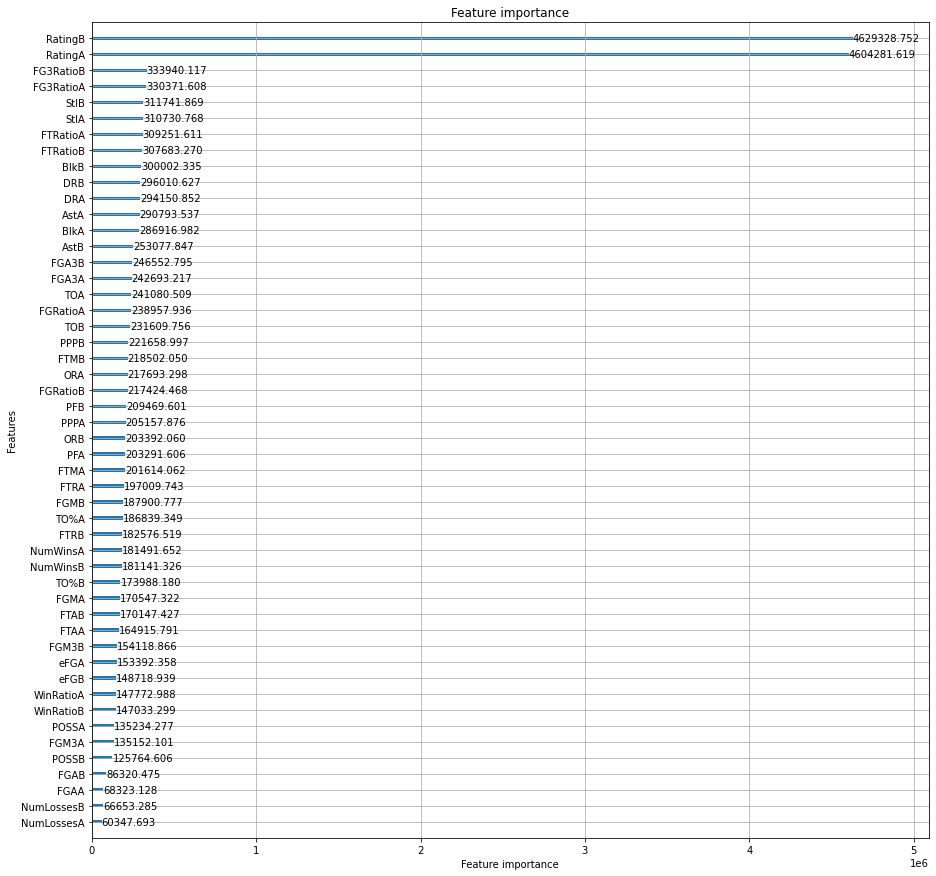

In [29]:
if TRAIN:
    fig,ax = plt.subplots(figsize=(15,15))
    lgb.plot_importance(model, ax=ax,importance_type='gain',max_num_features=50)
    plt.show();

## Inference

In [30]:
# submission
y_test_sub =  np.mean(y_test,axis=0)

sub = pd.read_csv(SUB_PATH)
sub["Pred"] = y_test_sub

sub.to_csv(SAVE_TEST_SUB_PATH,index=False)

In [31]:
#check
print(y_test)
print(y_test_sub.shape)

[array([-3.94853611e+00, -3.61840379e+00, -9.46100551e+00, ...,
        4.23829240e+00, -9.37631478e-03, -3.59846030e+00]), array([ -7.0992662 ,  -4.75132016, -11.1732312 , ...,   1.78016781,
        -4.1636831 ,  -5.09000177]), array([ -9.48333563,  -3.51738561, -11.63231687, ...,   3.51951146,
        -6.40676729,  -8.0609504 ]), array([ -8.9053902 ,  -3.77207042, -11.92352574, ...,   4.83651067,
        -4.49014147,  -7.51744267])]
(2278,)
